In [1]:
'''
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference: "3_mnist_from_scratch from", "docker run -it -p 8888:8888 gcr.io/tensorflow/tensorflow"
https://github.com/michael-iuzzolino/CIFAR_reader
'''
from __future__ import print_function

import tensorflow as tf
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module
from CIFAR_reader import CIFAR_reader

In [2]:
cifar = CIFAR_reader(one_hot=True, verbose=True, img_size=32, num_classes=10, augment=False)

Checking for CIFAR data...
Extracting Data...
Unpacking data...
Loading training batch 1 of 5...
Loading training batch 2 of 5...
Loading training batch 3 of 5...
Loading training batch 4 of 5...
Loading training batch 5 of 5...
Loading testing batch 1 of 1...


In [3]:
IMAGE_SIZE = 32
PIXEL_DEPTH = 255
BATCH_SIZE = 128
N_CHANNELS = 3
N_LABELS = 10
SEED = 32

training_data = cifar.train
training_labels = cifar.labels
train_data = training_data['data'][0:12000]
train_labels = training_data['labels'][0:12000]

testing_data = cifar.test
test_data = testing_data['data']
test_data = np.float32(test_data)
test_labels = testing_data['labels']
test_labels = np.float32(test_labels)

# convert train and test data values from [0, 255] to [-0.5, 0.5]
N_TRAIN_IMAGE = len(train_data)
train_data = (train_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
train_data = train_data.reshape(N_TRAIN_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)
print('N_TRAIN_IMAGE, ', N_TRAIN_IMAGE)

N_TEST_IMAGE = len(test_data)
test_data = (test_data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
test_data = test_data.reshape(N_TEST_IMAGE, IMAGE_SIZE, IMAGE_SIZE, 3)

#print("train_data[0]:", train_data[0])
#print("test_data[0]:", test_data[0])

N_TRAIN_IMAGE,  12000


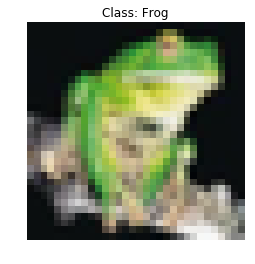

In [4]:
cifar.preview_data(data_set="training")

In [5]:
print (train_data.shape)
print (train_labels.shape)
print (test_data.shape)
print (test_labels.shape)

(12000, 32, 32, 3)
(12000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [6]:
VALIDATION_SIZE = len(train_data) / 5

validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_data = np.float32(validation_data)
validation_labels = train_labels[:VALIDATION_SIZE]
validation_size = len(validation_data)

train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_data = np.float32(train_data)
train_labels = train_labels[VALIDATION_SIZE:]
train_size = len(train_data)

# to verify validation and train data are splitted properly
print('validation_data[0][0][0]: \t', validation_data[0][0][0])
print('validation_data[0][0][1]: \t', validation_data[0][0][1])
print('train_data[0][0][0]: \t', train_data[0][0][0])
print('train_data[0][0][1]: \t', train_data[0][0][1])

print('train_data.shape\t', train_data.shape)
print('validation_data.shape\t', validation_data.shape)
print('train_data size:\t', train_size)
print('validation_data size:\t', validation_size)
#print('validation_data:', validation_data)
#print('validation_labels: ', validation_labels)

validation_data[0][0][0]: 	 [-0.26862746 -0.25686276 -0.25294119]
validation_data[0][0][1]: 	 [-0.33137256 -0.31960785 -0.32352942]
train_data[0][0][0]: 	 [ 0.30392158  0.23333333  0.13137256]
train_data[0][0][1]: 	 [ 0.2764706   0.18627451  0.10392157]
train_data.shape	 (9600, 32, 32, 3)
validation_data.shape	 (2400, 32, 32, 3)
train_data size:	 9600
validation_data size:	 2400


In [7]:
import tensorflow as tf

train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, N_LABELS))

train_all_data_node = tf.constant(train_data)
validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

conv1_weights = tf.Variable(
  tf.truncated_normal([10, 10, N_CHANNELS, 32],  # 5x5 kernel, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))
conv2_weights = tf.Variable(
  tf.truncated_normal([10, 10, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))
fc1_weights = tf.Variable(  # fully connected, depth 512.
  tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                      stddev=0.1,
                      seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
fc2_weights = tf.Variable(
  tf.truncated_normal([512, N_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[N_LABELS]))

print('Variables Initialized')

Variables Initialized


In [8]:
def model(data, train=False):

    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1], #[image index, y, x, depth]
                        padding='SAME')

    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    pool = tf.nn.max_pool(relu,
                          ksize=[1, 4, 4, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Fully connected layers
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the 
    # '+' operation automatically broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED) # drop out rate 50%
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Model defined')

Model defined


In [9]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  labels=train_labels_node, logits=logits))

# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
loss += 5e-4 * regularizers

batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)

# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)

# compute only by {eval()} method.
train_all_data_prediction = tf.nn.softmax(model(train_all_data_node))
validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Training computation: logits + cross-entropy loss done')

Training computation: logits + cross-entropy loss done


In [10]:
sess = tf.InteractiveSession()
sess.as_default()
tf.global_variables_initializer().run()

In [11]:
batch_data = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

# batch data
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = sess.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print(batch_data.shape)
print(batch_labels.shape)
print('Run graph done.')

(128, 32, 32, 3)
(128, 10)
Run graph done.


In [12]:
print(predictions[0])

[  8.14560294e-11   3.22916160e-09   1.81399848e-17   1.45459296e-12
   6.93455640e-11   8.00610613e-03   7.22223490e-15   9.91993904e-01
   4.35241339e-12   6.80071888e-10]


In [13]:
# The highest probability in the first entry.
print('First prediction', np.argmax(predictions[0]))
print(predictions.shape)
print('All predictions', np.argmax(predictions, 1))

First prediction 7
(128, 10)
All predictions [7 4 7 7 5 5 6 2 0 4 5 4 5 7 2 4 5 4 7 1 7 6 5 4 5 5 1 5 5 5 7 9 4 1 4 0 1
 5 6 7 5 0 7 2 5 5 4 1 5 2 0 5 1 5 7 8 0 5 5 5 0 5 0 7 5 7 6 7 5 5 0 0 7 4
 7 5 5 5 7 7 5 7 9 7 9 9 6 5 5 0 5 5 5 5 5 5 6 7 5 5 0 5 4 0 5 6 7 7 7 0 5
 7 5 9 5 6 5 2 0 7 7 7 4 4 8 9 5 5]


In [14]:
print('Batch labels', np.argmax(batch_labels, 1))

Batch labels [6 0 4 0 3 7 3 6 2 6 5 6 3 0 3 4 5 8 4 4 0 0 1 0 6 3 8 0 1 0 7 1 3 1 8 0 2
 9 8 6 5 8 4 3 4 1 0 3 9 7 4 0 3 0 8 1 1 5 7 0 0 4 8 8 8 4 1 2 9 1 2 8 7 0
 7 6 2 9 0 6 7 7 5 8 2 4 4 8 4 8 0 2 7 7 6 9 1 9 9 7 5 3 7 6 0 3 9 2 9 5 6
 1 0 0 2 4 5 6 3 6 4 3 5 8 9 3 9 3]


In [15]:
def get_accuracy(predictions, labels):
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    accuracy = float(correct) / float(total)
    accuracy_fig = ""
    accuracy_fig = str(correct)
    accuracy_fig += (" of ")
    accuracy_fig += str(total)
    return accuracy, accuracy_fig

print('get_accuracy defined')

get_accuracy defined


In [16]:
validation_accuracy, validation_accuracy_fig = get_accuracy(validation_prediction.eval(), validation_labels)
print('validation_prediction.shape', validation_prediction.shape)
print('Validation accuracy: %.4f%% (%s)' % (validation_accuracy * 100, validation_accuracy_fig))

validation_prediction.shape (2400, 10)
Validation accuracy: 15.9167% (382 of 2400)


In [ ]:
train_accuracy, train_accuracy_fig = get_accuracy(train_all_data_prediction.eval(), train_labels)
print('train_all_data_prediction.shape', train_all_data_prediction.shape)
print('Train accuracy: %.4f%% (%s)' % (train_accuracy * 100, train_accuracy_fig))

train_all_data_prediction.shape (9600, 10)
Train accuracy: 15.5000% (1488 of 9600)


In [ ]:
test_accuracy, test_accuracy_fig = get_accuracy(test_prediction.eval(), test_labels)
print('test_prediction.shape', test_prediction.shape)
print('Test accuracy: %.4f%% (%s)' % (test_accuracy * 100, test_accuracy_fig))

In [ ]:
#steps = train_size
steps = 2000
for step in range(steps):
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
    _, l, lr, predictions = sess.run([optimizer, loss, learning_rate, train_prediction], feed_dict=feed_dict)
    
    if step % 5 == 0:
        print('Step %d of %d' % (step, steps))
        validation_accuracy, validation_accuracy_fig = get_accuracy(
              validation_prediction.eval(), validation_labels)
        print(validation_prediction.shape)
        print('Validation accuracy: %.6f%% (%s), Mini-batch loss: %.5f, Learning rate: %.5f' % 
              (validation_accuracy * 100, validation_accuracy_fig, l, lr))
        
        print(train_all_data_prediction.shape)
        train_accuracy, train_accuracy_fig = get_accuracy(train_all_data_prediction.eval(), train_labels)
        print('train_all_data_prediction.shape', train_all_data_prediction.shape)
        print('Train accuracy: %.4f%% (%s)' % (train_accuracy * 100, train_accuracy_fig))
        #feed_train_all_data_dict = {train_all_data_node: train_data}
        #train_accuracy, train_accuracy_fig = get_accuracy(
         #     train_all_data_prediction.eval(feed_dict=feed_train_all_data_dict), 
         #   train_labels)
        
        #train_accuracy, train_accuracy_fig = get_accuracy(
        #      train_all_data_prediction.eval(), train_labels)
        
        #print('Train accuracy: %.6f%% (%s), Mini-batch loss: %.5f, Learning rate: %.5f' % 
         #     (train_accuracy * 100, train_accuracy_fig, l, lr))

In [ ]:
test_accuracy, test_accuracy_fig = get_accuracy(test_prediction.eval(), test_labels)
print('Test accuracy: %.4f%% (%s)' % (test_accuracy * 100, test_accuracy_fig))

In [ ]:
train_accuracy, train_accuracy_fig = get_accuracy(train_all_data_prediction.eval(), train_labels)
print('Train accuracy: %.4f%% (%s)' % (train_accuracy * 100, train_accuracy_fig))